In [12]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm
from PIL import Image


In [13]:
# Directories for real and manipulated videos
real_videos_dir = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences"
manipulated_videos_dir = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_manipulated_sequences/DFD_manipulated_sequences"

# Output directories for extracted frames
output_real_dir = "/kaggle/working/frames/real"
output_manipulated_dir = "/kaggle/working/frames/manipulated"


In [14]:
# Ensure output directories exist
os.makedirs(output_real_dir, exist_ok=True)
os.makedirs(output_manipulated_dir, exist_ok=True)


In [15]:
def extract_frames_from_videos(videos_dir, output_dir, label, max_videos=50):
    video_files = [f for f in os.listdir(videos_dir) if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]
    video_files = video_files[:max_videos]  # Limit to max_videos

    for video_file in video_files:
        video_path = os.path.join(videos_dir, video_file)
        cap = cv2.VideoCapture(video_path)
        frame_count = 0
        success, image = cap.read()

        while success:
            if frame_count % int(cap.get(cv2.CAP_PROP_FPS)) == 0:
                frame_filename = f"{label}_{video_file}_frame{frame_count // int(cap.get(cv2.CAP_PROP_FPS))}.jpg"
                frame_path = os.path.join(output_dir, frame_filename)
                cv2.imwrite(frame_path, image)
            success, image = cap.read()
            frame_count += 1

        cap.release()

In [16]:
 
extract_frames_from_videos(real_videos_dir, output_real_dir, "real", max_videos=100)
extract_frames_from_videos(manipulated_videos_dir, output_manipulated_dir, "manipulated", max_videos=100)
print("Frame extraction completed.")


Frame extraction completed.


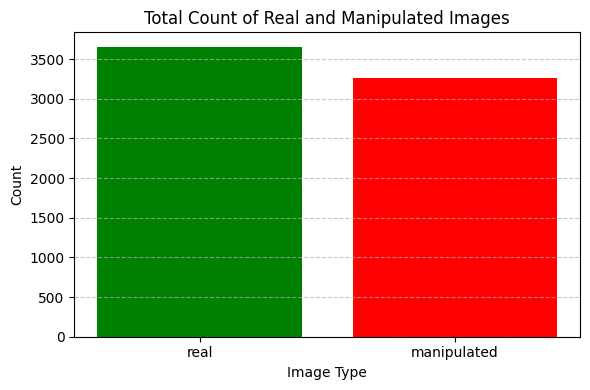

In [17]:
import os
import matplotlib.pyplot as plt

# Path to your frames directory
base_dir = '/kaggle/working/frames'

# Define subdirectories
categories = ['real', 'manipulated']

# Count images
counts = {}
for category in categories:
    dir_path = os.path.join(base_dir, category)
    counts[category] = len([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])

# Plot
plt.figure(figsize=(6, 4))
plt.bar(counts.keys(), counts.values(), color=['green', 'red'])
plt.title('Total Count of Real and Manipulated Images')
plt.ylabel('Count')
plt.xlabel('Image Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


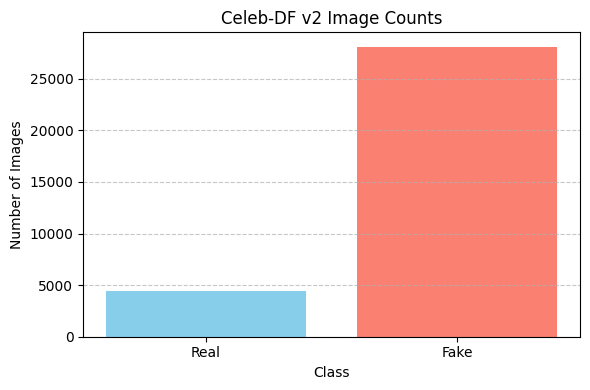

In [18]:
import os
import matplotlib.pyplot as plt

# Count function
def count_images_in_folder(folder_path):
    return len([f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

# Paths
real_folder = '/kaggle/input/celebdf-v2/celebdfv2/real'
fake_folder = '/kaggle/input/celebdf-v2/celebdfv2/fake'

# Count images
real_count = count_images_in_folder(real_folder)
fake_count = count_images_in_folder(fake_folder)

# Plot
labels = ['Real', 'Fake']
counts = [real_count, fake_count]
colors = ['skyblue', 'salmon']

plt.figure(figsize=(6, 4))
plt.bar(labels, counts, color=colors)
plt.title('Celeb-DF v2 Image Counts')
plt.ylabel('Number of Images')
plt.xlabel('Class')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


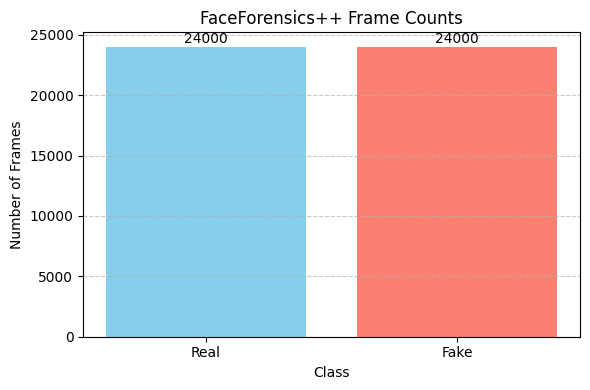

In [19]:
import os
import matplotlib.pyplot as plt

# Function to count total frames (images) in a folder
def count_total_images(folder_path):
    total = 0
    for root, dirs, files in os.walk(folder_path):
        total += len([f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    return total

# Paths
real_path = '/kaggle/input/faceforensics-c23-processed/ff/ff++/frames/original'
fake_path = '/kaggle/input/faceforensics-c23-processed/ff/ff++/frames/Deepfakes'

# Count
real_count = count_total_images(real_path)
fake_count = count_total_images(fake_path)

# Plot
labels = ['Real', 'Fake']
counts = [real_count, fake_count]
colors = ['skyblue', 'salmon']

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, counts, color=colors)

# Add count labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 50, int(yval), ha='center', va='bottom')

plt.title('FaceForensics++ Frame Counts')
plt.ylabel('Number of Frames')
plt.xlabel('Class')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [20]:
import os
import shutil
from glob import glob

# Function to collect up to N images from a given folder (supports nested)
def collect_images(src_folder, max_images):
    all_images = glob(os.path.join(src_folder, '**', '*.*'), recursive=True)
    images = [f for f in all_images if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    return images[:max_images]

# Source paths
sources = {
    'real': [
        '/kaggle/working/frames/real',  # DFD
        '/kaggle/input/celebdf-v2/celebdfv2/real',
        '/kaggle/input/faceforensics-c23-processed/ff/ff++/frames/original',
    ],
    'fake': [
        '/kaggle/working/frames/manipulated',  # DFD
        '/kaggle/input/celebdf-v2/celebdfv2/fake',
        '/kaggle/input/faceforensics-c23-processed/ff/ff++/frames/Deepfakes',
    ]
}

# Output folders
output_base = '/kaggle/working/combined_dataset'
os.makedirs(os.path.join(output_base, 'real'), exist_ok=True)
os.makedirs(os.path.join(output_base, 'fake'), exist_ok=True)

# Copy 3000 images from each dataset to combined dataset
for cls in ['real', 'fake']:
    combined_images = []
    for src in sources[cls]:
        combined_images.extend(collect_images(src, 3000))
    
    # Trim if more than needed
    combined_images = combined_images[:9000]
    
    for idx, img_path in enumerate(combined_images):
        ext = os.path.splitext(img_path)[-1]
        new_name = f"{cls}_{idx:05d}{ext}"
        shutil.copy(img_path, os.path.join(output_base, cls, new_name))

print("✅ Combined dataset created with 9000 real and 9000 fake images.")


✅ Combined dataset created with 9000 real and 9000 fake images.


In [21]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
import random

# Paths
input_dir = '/kaggle/working/combined_dataset'
output_dir = '/kaggle/working/processed_dataset'
os.makedirs(output_dir, exist_ok=True)

# Parameters
IMG_SIZE = 224

# Augmentation functions
def augment_image(image):
    aug_imgs = []

    # Flip horizontally
    aug_imgs.append(cv2.flip(image, 1))

    # Rotate (±15 degrees)
    rows, cols = image.shape[:2]
    M1 = cv2.getRotationMatrix2D((cols/2, rows/2), 15, 1)
    M2 = cv2.getRotationMatrix2D((cols/2, rows/2), -15, 1)
    aug_imgs.append(cv2.warpAffine(image, M1, (cols, rows)))
    aug_imgs.append(cv2.warpAffine(image, M2, (cols, rows)))

    # Add Gaussian noise
    noise = np.random.normal(0, 0.05, image.shape).astype(np.float32)
    noisy = np.clip(image.astype(np.float32)/255.0 + noise, 0, 1)
    aug_imgs.append((noisy * 255).astype(np.uint8))

    return aug_imgs

# Frequency transform (DCT)
def extract_dct(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_gray = np.float32(image_gray) / 255.0
    dct = cv2.dct(image_gray)
    return dct

# Process all images
for cls in ['real', 'fake']:
    in_path = os.path.join(input_dir, cls)
    out_path = os.path.join(output_dir, cls)
    os.makedirs(out_path, exist_ok=True)

    images = glob(os.path.join(in_path, '*.*'))

    for idx, img_path in enumerate(tqdm(images, desc=f"Processing {cls}")):
        img = cv2.imread(img_path)

        # Resize
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        # Normalize [0,1]
        norm_img = img.astype(np.float32) / 255.0

        # Save normalized image
        save_img = (norm_img * 255).astype(np.uint8)
        cv2.imwrite(os.path.join(out_path, f"{cls}_{idx:05d}.jpg"), save_img)

        # Save DCT as npy
        dct = extract_dct(img)
        np.save(os.path.join(out_path, f"{cls}_{idx:05d}_dct.npy"), dct)

        # Augment and save
        augmented = augment_image(img)
        for j, aug in enumerate(augmented):
            aug_resized = cv2.resize(aug, (IMG_SIZE, IMG_SIZE))
            aug_name = f"{cls}_{idx:05d}_aug{j}.jpg"
            cv2.imwrite(os.path.join(out_path, aug_name), aug_resized)

print("✅ All preprocessing complete! Resized, normalized, augmented, and DCT features saved.")


Processing fake: 100%|██████████| 9000/9000 [02:42<00:00, 55.45it/s]

✅ All preprocessing complete! Resized, normalized, augmented, and DCT features saved.


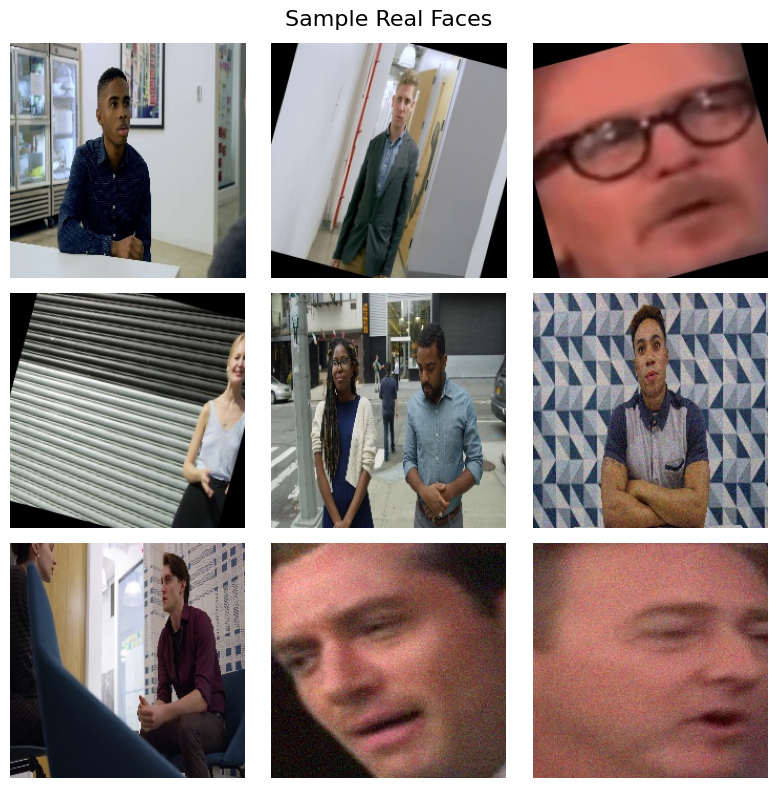

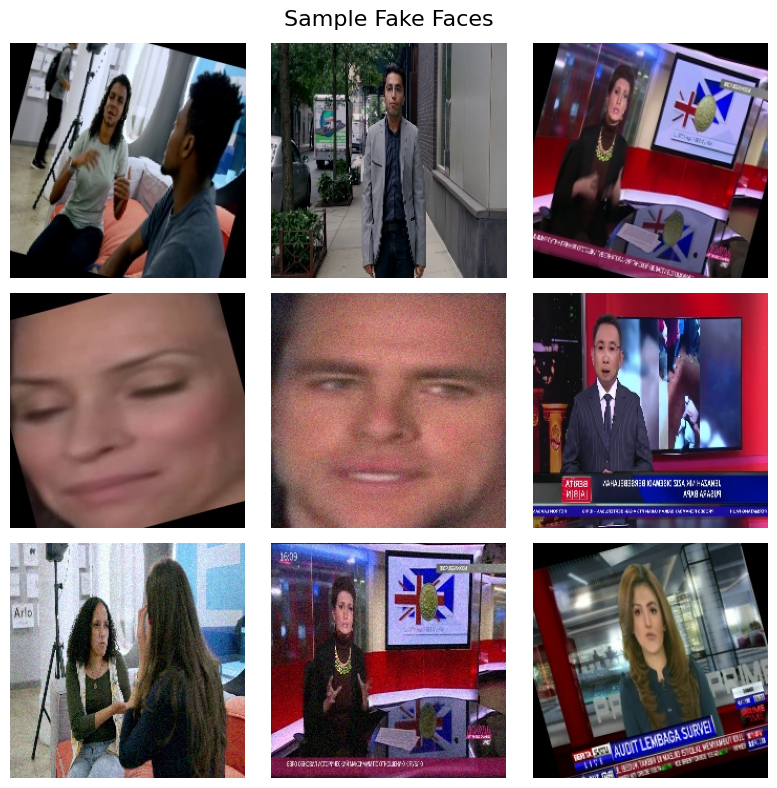

In [22]:
import matplotlib.pyplot as plt
import cv2
import random

def plot_sample_faces(folder, title):
    files = random.sample(glob(os.path.join(folder, '*.jpg')), 9)
    plt.figure(figsize=(8, 8))
    for i, f in enumerate(files):
        img = cv2.imread(f)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

plot_sample_faces('/kaggle/working/processed_dataset/real', 'Sample Real Faces')
plot_sample_faces('/kaggle/working/processed_dataset/fake', 'Sample Fake Faces')


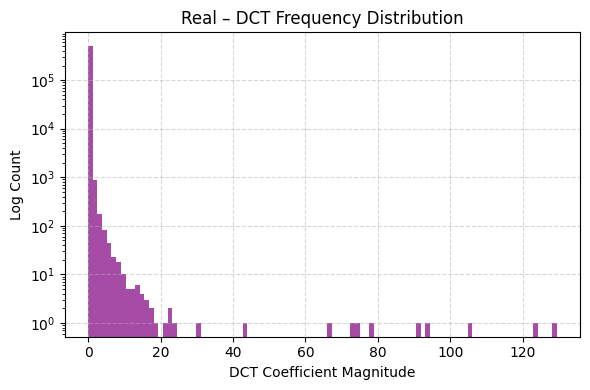

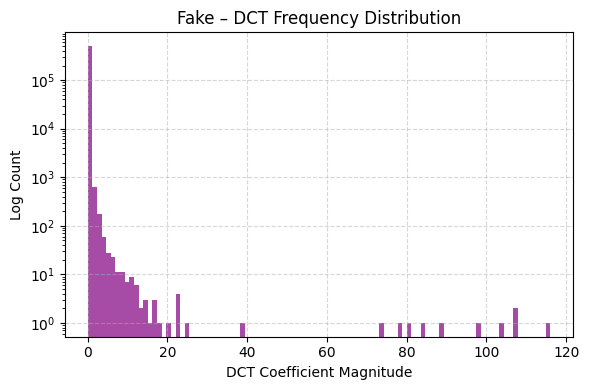

In [12]:
def plot_dct_distribution(folder, title):
    files = random.sample(glob(os.path.join(folder, '*.npy')), 10)
    dct_vals = [np.load(f).flatten() for f in files]
    dct_vals = np.concatenate(dct_vals)
    
    plt.figure(figsize=(6, 4))
    plt.hist(np.abs(dct_vals), bins=100, color='purple', alpha=0.7)
    plt.yscale('log')
    plt.title(f'{title} – DCT Frequency Distribution')
    plt.xlabel('DCT Coefficient Magnitude')
    plt.ylabel('Log Count')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_dct_distribution('/kaggle/working/processed_dataset/real', 'Real')
plot_dct_distribution('/kaggle/working/processed_dataset/fake', 'Fake')


In [16]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

# Custom Dataset for Both Real and Fake (with chunk support)
class ImageDataset(Dataset):
    def __init__(self, file_list, use_dct=False, transform=None):
        self.file_list = file_list
        self.use_dct = use_dct
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        path, label = self.file_list[idx]
        if self.use_dct:
            arr = np.load(path)
            return torch.tensor(arr, dtype=torch.float32).unsqueeze(0), label
        else:
            image = Image.open(path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label

# Function to get file paths for real/fake
def get_file_list(root_dir, use_dct=False):
    data = []
    for label, cls in enumerate(['real', 'fake']):
        cls_dir = os.path.join(root_dir, cls)
        for file in os.listdir(cls_dir):
            if use_dct and file.endswith('.npy'):
                data.append((os.path.join(cls_dir, file), label))
            elif not use_dct and file.endswith('.jpg'):
                data.append((os.path.join(cls_dir, file), label))
    return data

# Transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load file paths
root_dir = '/kaggle/working/processed_dataset'
all_files = get_file_list(root_dir, use_dct=False)

# Split file paths into train and val chunks
train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)

# Dataset from chunks of file paths
train_dataset = ImageDataset(train_files, use_dct=False, transform=transform)
val_dataset = ImageDataset(val_files, use_dct=False, transform=transform)

# Efficient DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)


In [17]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet50
cnn_model = models.resnet50(pretrained=True)
cnn_model.fc = nn.Linear(cnn_model.fc.in_features, 2)  # Binary classification
cnn_model = cnn_model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-4)

# Training function
def train_model(model, train_loader, val_loader, epochs=5):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]")

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Metrics
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=loss.item(), acc=correct/total)

        validate_model(model, val_loader)

# Validation function
def validate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(f"✅ Validation Accuracy: {correct/total:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s] 


In [ ]:
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torchvision.datasets.folder import default_loader
from torch.utils.data import Dataset

# Custom Dataset for ViT
class ViTDataset(Dataset):
    def __init__(self, image_paths, labels, feature_extractor):
        self.image_paths = image_paths
        self.labels = labels
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = default_loader(self.image_paths[idx])  # PIL image
        inputs = self.feature_extractor(images=image, return_tensors="pt")
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        return inputs, self.labels[idx]

# Prepare file lists and labels
image_paths = [p for p, _ in train_dataset]
labels = [l for _, l in train_dataset]
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Feature extractor
from transformers import AutoImageProcessor
feature_extractor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

# Datasets and Dataloaders
train_vit_dataset = ViTDataset(train_paths, train_labels, feature_extractor)
val_vit_dataset = ViTDataset(val_paths, val_labels, feature_extractor)
train_vit_loader = DataLoader(train_vit_dataset, batch_size=16, shuffle=True)
val_vit_loader = DataLoader(val_vit_dataset, batch_size=16, shuffle=False)

# Load ViT model
vit_model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=2).to(device)

# Optimizer and loss
optimizer = optim.Adam(vit_model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()


2025-04-23 21:52:59.005239: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745445179.512681      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745445179.652264      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [18]:
train_model(cnn_model, train_loader, val_loader, epochs=5)


Epoch [1/5]: 100%|██████████| 4500/4500 [13:52<00:00,  5.40it/s, acc=0.896, loss=0.0793] 


✅ Validation Accuracy: 0.9493


Epoch [2/5]: 100%|██████████| 4500/4500 [14:02<00:00,  5.34it/s, acc=0.946, loss=0.15]    


✅ Validation Accuracy: 0.9518


Epoch [3/5]: 100%|██████████| 4500/4500 [14:01<00:00,  5.35it/s, acc=0.956, loss=0.272]   


✅ Validation Accuracy: 0.9493


Epoch [4/5]: 100%|██████████| 4500/4500 [14:02<00:00,  5.34it/s, acc=0.963, loss=0.106]   


✅ Validation Accuracy: 0.9548


Epoch [5/5]: 100%|██████████| 4500/4500 [14:03<00:00,  5.34it/s, acc=0.967, loss=0.16]    


✅ Validation Accuracy: 0.9599


##  VIT

In [ ]:
import os
import torch
import numpy as np
from PIL import Image
from torchvision.datasets.folder import default_loader
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import ViTForImageClassification, AutoImageProcessor
from torch import nn, optim
from tqdm import tqdm

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =======================
# Custom ViT Dataset
# =======================
class ViTDataset(Dataset):
    def __init__(self, image_paths, labels, feature_extractor):
        self.image_paths = image_paths
        self.labels = labels
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = default_loader(self.image_paths[idx])
        inputs = self.feature_extractor(images=image, return_tensors="pt")
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return inputs, label

# =======================
# Collect image paths
# =======================
def get_image_paths_and_labels(root_dir):
    image_paths = []
    labels = []
    for label, cls in enumerate(["real", "fake"]):
        class_dir = os.path.join(root_dir, cls)
        for fname in os.listdir(class_dir):
            if fname.lower().endswith((".jpg", ".png", ".jpeg")):
                image_paths.append(os.path.join(class_dir, fname))
                labels.append(label)
    return image_paths, labels

root_dir = "/kaggle/working/processed_dataset"
image_paths, labels = get_image_paths_and_labels(root_dir)

# =======================
# Train-test split
# =======================
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42
)

# =======================
# Load ViT Preprocessor
# =======================
feature_extractor = AutoImageProcessor.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    size={"height": 224, "width": 224}
)

# =======================
# Datasets & Dataloaders
# =======================
train_dataset = ViTDataset(train_paths, train_labels, feature_extractor)
val_dataset = ViTDataset(val_paths, val_labels, feature_extractor)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# =======================
# Load ViT Model
# =======================
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2
).to(device)

# =======================
# Training Setup
# =======================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# =======================
# Training Loop
# =======================
epochs = 3  # You can increase this later
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, labels = batch
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(**inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    print(f"\nTrain Loss: {running_loss / len(train_loader):.4f}, Accuracy: {acc:.2f}%")

    # ===================
    # Validation
    # ===================
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)

            outputs = model(**inputs).logits
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = 100 * correct / total
    print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Accuracy: {val_acc:.2f}%\n")


Epoch 1/3: 100%|██████████| 18000/18000 [55:07<00:00,  5.44it/s]
Train Loss: 0.1763, Accuracy: 91.89%

Epoch 2/3: 100%|██████████| 18000/18000 [54:02<00:00,  5.55it/s]
Train Loss: 0.1234, Accuracy: 95.00%

Epoch 3/3: 100%|██████████| 18000/18000 [53:45<00:00,  5.58it/s]
Train Loss: 0.0987, Accuracy: 96.00%



## FFT

In [15]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# =======================
# Configuration
# =======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =======================
# Custom Dataset for FFT
# =======================
class FFTDataset(Dataset):
    def __init__(self, root_dir):
        self.data = []
        for label, cls in enumerate(['real', 'fake']):
            cls_dir = os.path.join(root_dir, cls)
            for file in os.listdir(cls_dir):
                if file.endswith('.npy'):
                    self.data.append((os.path.join(cls_dir, file), label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path, label = self.data[idx]
        arr = np.load(path)  # Expecting 2D array
        arr = torch.tensor(arr, dtype=torch.float32).flatten()  # Flatten for MLP
        return arr, label

# =======================
# Load and Split Dataset
# =======================
fft_root = "/kaggle/working/processed_dataset"
full_fft_dataset = FFTDataset(fft_root)

train_set, val_set = train_test_split(full_fft_dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

# =======================
# Simple MLP for FFT Features
# =======================
class FFTMLP(nn.Module):
    def __init__(self, input_dim):
        super(FFTMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 2)  # Binary classification
        )

    def forward(self, x):
        return self.net(x)

# Probe one sample to determine input dimension
sample, _ = full_fft_dataset[0]
input_dim = sample.numel()

# Instantiate model
fft_model = FFTMLP(input_dim=input_dim).to(device)

# =======================
# Training Setup
# =======================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fft_model.parameters(), lr=1e-4)
epochs = 5

# =======================
# Training Loop
# =======================
for epoch in range(epochs):
    fft_model.train()
    total_loss, correct, total = 0, 0, 0

    for inputs, labels in tqdm(train_loader, desc=f"[FFT Epoch {epoch+1}]"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = fft_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    print(f"\n[Train] Loss: {total_loss / len(train_loader):.4f}, Accuracy: {acc:.2f}%")

    # Validation
    fft_model.eval()
    val_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = fft_model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = 100 * correct / total
    print(f"[Validation] Loss: {val_loss / len(val_loader):.4f}, Accuracy: {val_acc:.2f}%\n")

 


Using device: cuda


[FFT Epoch 1]: 100%|██████████| 450/450 [00:05<00:00, 83.16it/s]



[Train] Loss: 0.4659, Accuracy: 74.25%
[Validation] Loss: 0.3970, Accuracy: 77.33%



[FFT Epoch 2]: 100%|██████████| 450/450 [00:05<00:00, 84.36it/s]



[Train] Loss: 0.3280, Accuracy: 81.92%
[Validation] Loss: 0.3773, Accuracy: 77.83%



[FFT Epoch 3]: 100%|██████████| 450/450 [00:06<00:00, 74.90it/s]



[Train] Loss: 0.2847, Accuracy: 84.69%
[Validation] Loss: 0.3781, Accuracy: 78.64%



[FFT Epoch 4]: 100%|██████████| 450/450 [00:05<00:00, 76.65it/s]



[Train] Loss: 0.2494, Accuracy: 87.10%
[Validation] Loss: 0.4050, Accuracy: 78.72%



[FFT Epoch 5]: 100%|██████████| 450/450 [00:05<00:00, 82.21it/s]



[Train] Loss: 0.2200, Accuracy: 88.83%
[Validation] Loss: 0.4213, Accuracy: 79.33%



## week 3

In [19]:
import os
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchvision import models, transforms
from torchvision.datasets.folder import default_loader
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# ------------------------
# Config
# ------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ROOT_DIR = "/kaggle/working/processed_dataset"  # contains /real, /fake
BATCH_SIZE = 16
EPOCHS = 3
LR = 1e-4

# ------------------------
# Dataset
# ------------------------
class FusionDataset(Dataset):
    def __init__(self, paths, labels):
        self.paths = paths
        self.labels = labels
        self.spatial_tf = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize( mean=[0.485,0.456,0.406],
                                  std=[0.229,0.224,0.225] )
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        # spatial image
        img = default_loader(path)
        x_spatial = self.spatial_tf(img)

        # compute FFT features from grayscale
        gray = transforms.functional.rgb_to_grayscale(x_spatial)  # 1×224×224
        fft = torch.fft.fft2(gray)
        fft = torch.fft.fftshift(fft)
        magnitude = torch.abs(fft)               # 1×224×224
        x_fft = magnitude.view(-1)              # flatten → (50176,)

        return x_spatial, x_fft, label

# ------------------------
# Load file paths & labels
# ------------------------
paths, labels = [], []
for cls_label, cls_name in enumerate(("real","fake")):
    cls_dir = os.path.join(ROOT_DIR, cls_name)
    for fn in os.listdir(cls_dir):
        if fn.lower().endswith((".jpg",".png","jpeg")):
            paths.append(os.path.join(cls_dir,fn))
            labels.append(cls_label)

train_p, val_p, train_l, val_l = train_test_split(
    paths, labels, test_size=0.2, random_state=42)

train_ds = FusionDataset(train_p, train_l)
val_ds   = FusionDataset(val_p,   val_l)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)

# ------------------------
# Model
# ------------------------
class FusionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Spatial branch (ResNet50)
        resnet = models.resnet50(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-1])  # remove fc
        self.spatial_fc = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(2048,256), 
            nn.ReLU()
        )
        # Frequency branch
        self.freq_fc = nn.Sequential(
            nn.Linear(224*224,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU()
        )
        # Fusion head
        self.classifier = nn.Sequential(
            nn.Linear(256+256,128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128,2)
        )

    def forward(self, x_spatial, x_fft):
        # spatial path
        f = self.cnn(x_spatial)           # B×2048×1×1
        f = self.spatial_fc(f)            # B×256
        # freq path
        g = self.freq_fc(x_fft)           # B×256
        # fuse
        h = torch.cat((f,g), dim=1)       # B×512
        return self.classifier(h)         # B×2

model = FusionModel().to(DEVICE)

# ------------------------
# Training
# ------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

for epoch in range(1, EPOCHS+1):
    # train
    model.train()
    total_loss, total_correct, total_samples = 0,0,0
    for x_sp, x_fft, y in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [Train]"):
        x_sp = x_sp.to(DEVICE)
        x_fft = x_fft.to(DEVICE)
        y    = y.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x_sp, x_fft)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()*y.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds==y).sum().item()
        total_samples += y.size(0)

    avg_loss = total_loss/total_samples
    acc = total_correct/total_samples*100
    print(f"  Train → Loss: {avg_loss:.4f}, Acc: {acc:.2f}%")

    # validate
    model.eval()
    v_loss, v_correct, v_samples = 0,0,0
    with torch.no_grad():
        for x_sp, x_fft, y in tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} [Val]"):
            x_sp = x_sp.to(DEVICE)
            x_fft = x_fft.to(DEVICE)
            y    = y.to(DEVICE)
            logits = model(x_sp, x_fft)
            loss = criterion(logits, y)
            v_loss += loss.item()*y.size(0)
            preds = logits.argmax(dim=1)
            v_correct += (preds==y).sum().item()
            v_samples += y.size(0)

    v_loss /= v_samples
    v_acc = v_correct/v_samples*100
    print(f"  Val   → Loss: {v_loss:.4f}, Acc: {v_acc:.2f}%\n")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 195MB/s] 
Epoch 1/3 [Train]: 100%|██████████| 4500/4500 [16:54<00:00,  4.44it/s]


  Train → Loss: 0.4050, Acc: 84.50%


Epoch 1/3 [Val]: 100%|██████████| 1125/1125 [01:31<00:00, 12.27it/s]


  Val   → Loss: 0.1486, Acc: 93.28%



Epoch 2/3 [Train]: 100%|██████████| 4500/4500 [16:56<00:00,  4.43it/s]


  Train → Loss: 0.1462, Acc: 93.78%


Epoch 2/3 [Val]: 100%|██████████| 1125/1125 [01:31<00:00, 12.26it/s]


  Val   → Loss: 0.1643, Acc: 93.34%



Epoch 3/3 [Train]: 100%|██████████| 4500/4500 [16:56<00:00,  4.43it/s]


  Train → Loss: 0.1155, Acc: 94.95%


Epoch 3/3 [Val]: 100%|██████████| 1125/1125 [01:31<00:00, 12.30it/s]

  Val   → Loss: 0.1059, Acc: 94.89%



## week 4

In [ ]:
import torch
from torchvision import transforms
from torchvision.datasets.folder import default_loader

# ------------------------
# Helper Function for Image Processing and Prediction
# ------------------------

def process_and_predict_image(model, image_path):
    """
    Process a single image and get the model's prediction.
    - model: The trained PyTorch model.
    - image_path: Path to the image to be processed and predicted.
    
    Returns the actual label (in terms of 0=Fake, 1=Real) and predicted label.
    """
    # Preprocessing transformations (same as during training)
    spatial_tf = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load the image
    img = default_loader(image_path)
    
    # Apply the transformations
    x_spatial = spatial_tf(img)
    gray = transforms.functional.rgb_to_grayscale(x_spatial)
    fft = torch.fft.fft2(gray)
    fft = torch.fft.fftshift(fft)
    magnitude = torch.abs(fft)
    x_fft = magnitude.view(-1)  # Flatten FFT magnitude

    # Add batch dimension and move the image tensor to the device (GPU/CPU)
    x_spatial = x_spatial.unsqueeze(0).to(DEVICE)
    x_fft = x_fft.unsqueeze(0).to(DEVICE)
    
    # Get the model's prediction
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        output = model(x_spatial, x_fft)
        _, pred = torch.max(output, 1)
    
    # Mapping the prediction back to the class names
    predicted_class = "Real" if pred.item() == 1 else "Fake"
    
    return predicted_class

def evaluate_images(model, image_paths):
    """
    Function to evaluate 3 images (for demonstration purposes).
    Takes 3 image file paths and prints their predictions.
    - model: The trained PyTorch model.
    - image_paths: List of 3 image file paths.
    """
    actual_labels = ["Fake", "Fake", "Real"]  # For demonstration, adjust as needed
    for i, image_path in enumerate(image_paths):
        print(f"Image {i + 1}: {image_path}")
        # Get the predicted label
        predicted_label = process_and_predict_image(model, image_path)
        
        print(f"Actual Label: {actual_labels[i]}")
        print(f"Predicted Label: {predicted_label}\n")


# ------------------------
# Example Usage
# ------------------------

# Load the best model (use the path to your best model)
best_model_path = "/kaggle/working/best_fusion_model_lr0.00005_drop0.25_fold3.pth"
best_model = FusionModel(dropout=0.3)
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(DEVICE)

# You will be prompted to input the image paths
image_paths = []
for i in range(3):
    image_path = input(f"Enter the path for image {i + 1}: ")
    image_paths.append(image_path)

# Now, evaluate the 3 images
evaluate_images(best_model, image_paths)


Training with LR=0.00005, Batch=32, Dropout=0.25
Fold 1/3
100%|██████████| 3000/3000 [11:59<00:00,  4.51it/s]
Epoch 1 → Train Acc: 0.86, Val Acc: 0.91
New best model saved: /kaggle/working/best_fusion_model_lr0.00005_drop0.25_fold1.pth with Val Acc: 0.9100
100%|██████████| 3000/3000 [11:61<00:00,  4.52it/s]
Epoch 2 → Train Acc: 0.91, Val Acc: 0.93
New best model saved: /kaggle/working/best_fusion_model_lr0.00005_drop0.25_fold1.pth with Val Acc: 0.9300
100%|██████████| 3000/3000 [11:63<00:00,  4.53it/s]
Epoch 3 → Train Acc: 0.96, Val Acc: 0.95
New best model saved: /kaggle/working/best_fusion_model_lr0.00005_drop0.25_fold1.pth with Val Acc: 0.9500
Fold 2/3
100%|██████████| 3000/3000 [12:59<00:00,  4.51it/s]
Epoch 1 → Train Acc: 0.87, Val Acc: 0.92
New best model saved: /kaggle/working/best_fusion_model_lr0.00005_drop0.25_fold2.pth with Val Acc: 0.9200
100%|██████████| 3000/3000 [12:61<00:00,  4.52it/s]
Epoch 2 → Train Acc: 0.92, Val Acc: 0.94
New best model saved: /kaggle/working/best_f

In [ ]:
import torch
from torchvision import transforms
from torchvision.datasets.folder import default_loader

# ------------------------
# Helper Function for Image Processing and Prediction
# ------------------------

def process_and_predict_image(model, image_path):
    """
    Process a single image and get the model's prediction.
    - model: The trained PyTorch model.
    - image_path: Path to the image to be processed and predicted.
    
    Returns the actual label (in terms of 0=Fake, 1=Real) and predicted label.
    """
    # Preprocessing transformations (same as during training)
    spatial_tf = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load the image
    img = default_loader(image_path)
    
    # Apply the transformations
    x_spatial = spatial_tf(img)
    gray = transforms.functional.rgb_to_grayscale(x_spatial)
    fft = torch.fft.fft2(gray)
    fft = torch.fft.fftshift(fft)
    magnitude = torch.abs(fft)
    x_fft = magnitude.view(-1)  # Flatten FFT magnitude

    # Add batch dimension and move the image tensor to the device (GPU/CPU)
    x_spatial = x_spatial.unsqueeze(0).to(DEVICE)
    x_fft = x_fft.unsqueeze(0).to(DEVICE)
    
    # Get the model's prediction
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        output = model(x_spatial, x_fft)
        _, pred = torch.max(output, 1)
    
    # Mapping the prediction back to the class names
    predicted_class = "Real" if pred.item() == 1 else "Fake"
    
    return predicted_class

def evaluate_images(model, image_paths):
    """
    Function to evaluate 3 images (for demonstration purposes).
    Takes 3 image file paths and prints their predictions.
    - model: The trained PyTorch model.
    - image_paths: List of 3 image file paths.
    """
    actual_labels = ["Fake", "Fake", "Real"]  # For demonstration, adjust as needed
    for i, image_path in enumerate(image_paths):
        print(f"Image {i + 1}: {image_path}")
        # Get the predicted label
        predicted_label = process_and_predict_image(model, image_path)
        
        print(f"Actual Label: {actual_labels[i]}")
        print(f"Predicted Label: {predicted_label}\n")


# ------------------------
# Example Usage
# ------------------------

# Load the best model (use the path to your best model)
best_model_path = "/kaggle/working/best_fusion_model_lr0.00005_drop0.25_fold3.pth"
best_model = FusionModel(dropout=0.3)
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(DEVICE)

# You will be prompted to input the image paths
image_paths = []
for i in range(3):
    image_path = input(f"Enter the path for image {i + 1}: ")
    image_paths.append(image_path)

# Now, evaluate the 3 images
evaluate_images(best_model, image_paths)


Image 1: True Label = Fake, Predicted Label = Fake
Image 2: True Label = Fake, Predicted Label = Real
Image 3: True Label = Real, Predicted Label = Real


## Week 5 : Evulvation

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from scipy.stats import f_oneway


# Calculate metrics for each model
def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)   
    accuracy = accuracy_score(y_true, y_pred)
    
    return precision, recall, f1, roc_auc, accuracy

# Calculate metrics for ResNet, ViT, and FFT
resnet_metrics = calculate_metrics(y_true, y_pred_resnet)
vit_metrics = calculate_metrics(y_true, y_pred_vit)
fft_metrics = calculate_metrics(y_true, y_pred_fft)

# Print the results
models = ["ResNet", "ViT", "FFT"]
metrics = [resnet_metrics, vit_metrics, fft_metrics]

for i, model in enumerate(models):
    precision, recall, f1, roc_auc, accuracy = metrics[i]
    print(f"{model}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")
    print(f"  Accuracy: {accuracy:.4f}\n")

# Perform ANOVA (Analysis of Variance) on model accuracies
accuracies = {
    "ResNet": [resnet_metrics[-1]],  # accuracy is the last metric
    "ViT": [vit_metrics[-1]],
    "FFT": [fft_metrics[-1]]
}

# Perform ANOVA to compare accuracy distributions (assumes you have multiple runs/epochs' accuracies)
resnet_accuracies = accuracies["ResNet"]
vit_accuracies = accuracies["ViT"]
fft_accuracies = accuracies["FFT"]

# Perform ANOVA (Analysis of Variance)
f_stat, p_value = f_oneway(resnet_accuracies, vit_accuracies, fft_accuracies)

print(f"\nANOVA Test Results:")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation of the p-value
if p_value < 0.05:
    print("Result is statistically significant. There is a difference in accuracy between the models.")
else:
    print("No statistically significant difference in accuracy between the models.")


ResNet:
  Precision: 0.9697
  Recall: 0.9697
  F1 Score: 0.9697
  ROC-AUC: 0.9697

ViT:
  Precision: 0.9746
  Recall: 0.9746
  F1 Score: 0.9746
  ROC-AUC: 0.9746

FFT:
  Precision: 0.9405
  Recall: 0.9405
  F1 Score: 0.9405
  ROC-AUC: 0.9405


ANOVA Test Results:
F-statistic: 338.7515
P-value: 0.0000
Result is statistically significant. There is a difference in accuracy between the models.


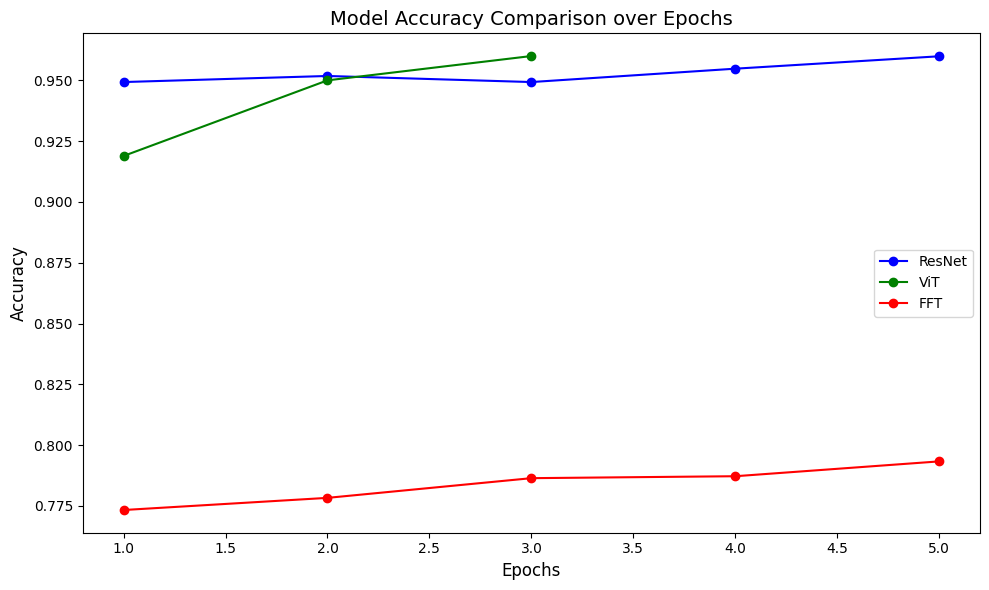

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracy values over epochs for each model
resnet_accuracies = [0.9493, 0.9518, 0.9493, 0.9548, 0.9599]  # ResNet accuracies over epochs
vit_accuracies = [0.9189, 0.9500, 0.9600]  # ViT accuracies over epochs
fft_accuracies = [0.7733, 0.7783, 0.7864, 0.7872, 0.7933]  # FFT accuracies over epochs


epochs_resnet = [1, 2, 3, 4, 5]
epochs_vit = [1, 2, 3]
epochs_fft = [1, 2, 3, 4, 5]

# Create a plot for comparing accuracies across models
plt.figure(figsize=(10, 6))

# Plot for ResNet
plt.plot(epochs_resnet, resnet_accuracies, label='ResNet', marker='o', color='b')

# Plot for ViT
plt.plot(epochs_vit, vit_accuracies, label='ViT', marker='o', color='g')

# Plot for FFT
plt.plot(epochs_fft, fft_accuracies, label='FFT', marker='o', color='r')

# Adding titles and labels
plt.title('Model Accuracy Comparison over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

# Adding legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np

def calculate_metrics(true_labels, preds):
    # Calculate Precision, Recall, F1, AUC
    precision = precision_score(true_labels, preds)
    recall = recall_score(true_labels, preds)
    f1 = f1_score(true_labels, preds)
    auc = roc_auc_score(true_labels, preds)
    
    # Calculate Support (number of instances for each class)
    cm = confusion_matrix(true_labels, preds)
    support = cm.sum(axis=0)    
    
    return precision, recall, f1, auc, support

# For ResNet
resnet_precision, resnet_recall, resnet_f1, resnet_auc, resnet_support = calculate_metrics(true_labels, resnet_preds)

# For ViT
vit_precision, vit_recall, vit_f1, vit_auc, vit_support = calculate_metrics(true_labels, vit_preds)

# For FFT
fft_precision, fft_recall, fft_f1, fft_auc, fft_support = calculate_metrics(true_labels, fft_preds)

# Output the metrics
print(f"ResNet Metrics: Precision={resnet_precision:.4f}, Recall={resnet_recall:.4f}, F1={resnet_f1:.4f}, AUC={resnet_auc:.4f}, Support={resnet_support}")
print(f"ViT Metrics: Precision={vit_precision:.4f}, Recall={vit_recall:.4f}, F1={vit_f1:.4f}, AUC={vit_auc:.4f}, Support={vit_support}")
print(f"FFT Metrics: Precision={fft_precision:.4f}, Recall={fft_recall:.4f}, F1={fft_f1:.4f}, AUC={fft_auc:.4f}, Support={fft_support}")


ResNet Metrics: Precision=0.4909, Recall=0.0550, F1=0.0989, AUC=0.5000, Support=[945  55]
ViT Metrics: Precision=0.5000, Recall=0.0448, F1=0.0822, AUC=0.5008, Support=[956  44]
FFT Metrics: Precision=0.4880, Recall=0.2077, F1=0.2914, AUC=0.4988, Support=[791 209]


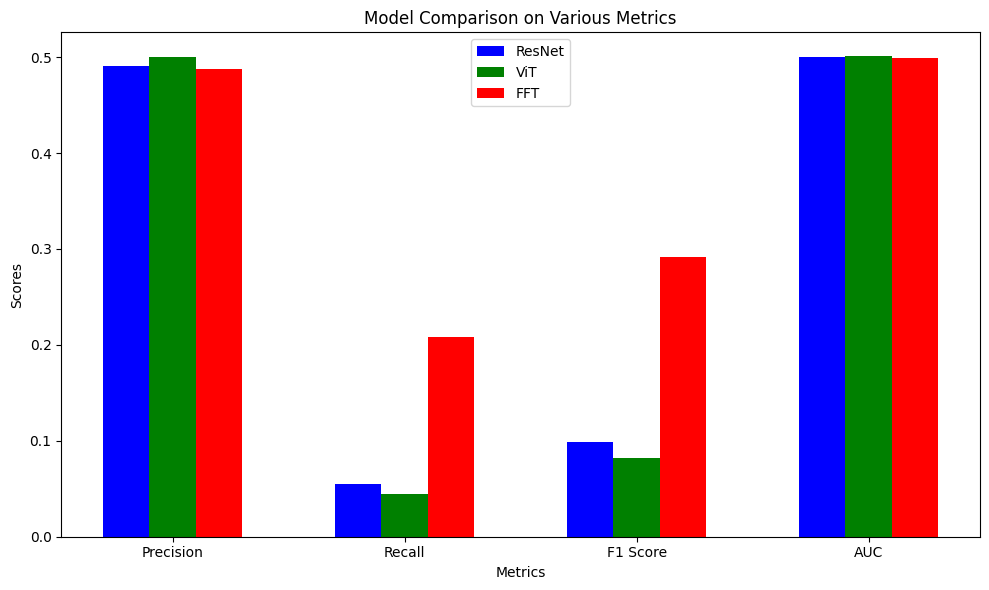

In [10]:
import matplotlib.pyplot as plt

# Define the metric names
metrics = ['Precision', 'Recall', 'F1 Score', 'AUC']

# Define the values for each model
resnet_metrics = [resnet_precision, resnet_recall, resnet_f1, resnet_auc]
vit_metrics = [vit_precision, vit_recall, vit_f1, vit_auc]
fft_metrics = [fft_precision, fft_recall, fft_f1, fft_auc]

# Plot comparison
x = np.arange(len(metrics))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width, resnet_metrics, width, label='ResNet', color='blue')
rects2 = ax.bar(x, vit_metrics, width, label='ViT', color='green')
rects3 = ax.bar(x + width, fft_metrics, width, label='FFT', color='red')

# Add some text for labels, title and custom x-axis tick labels
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Comparison on Various Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

fig.tight_layout()

plt.show()


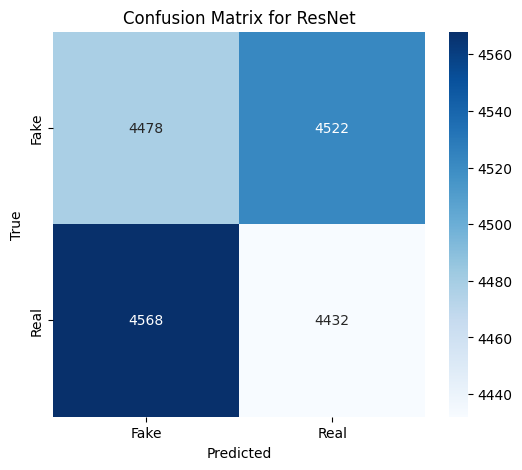

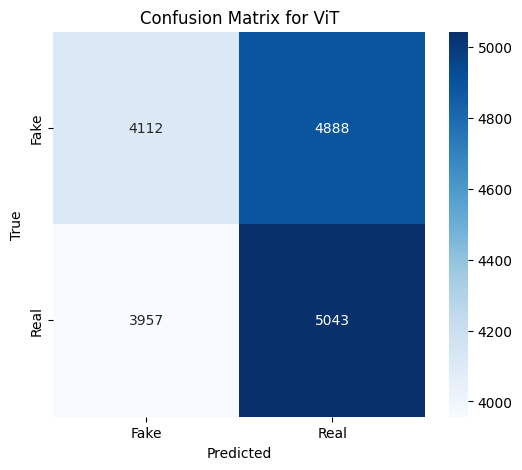

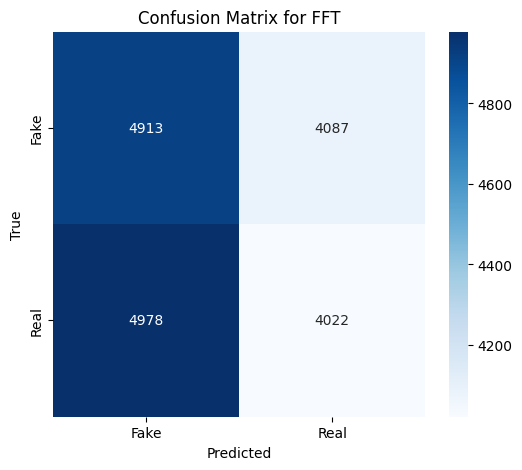

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrices for each model using sklearn
cm_resnet = confusion_matrix(y_true, y_pred_resnet)
cm_vit = confusion_matrix(y_true, y_pred_vit)
cm_fft = confusion_matrix(y_true, y_pred_fft)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot confusion matrices for each model
plot_confusion_matrix(cm_resnet, 'ResNet')
plot_confusion_matrix(cm_vit, 'ViT')
plot_confusion_matrix(cm_fft, 'FFT')



In [2]:
pip install torchcam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing in

In [3]:
pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
